In [9]:
import numpy as np
import random as rnd
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')

# creating object that will represent the deck to be drawn from
deck = np.tile(np.append(np.arange(1,11), np.tile(10,3)), 4)

# parameters and objects specific to Monte Carlo RL
gamma = 1
π = np.ones(shape = (10,10,2,2)) * 0.5
a_space = np.array([0,1])
sa_counter = np.zeros(shape = (10,10,2,2))
sa_returns = np.zeros(shape = (10,10,2,2))
Q = np.zeros(shape = (10,10,2,2))
ε = .1

# number of episodes to run
episodes = 10000000

# loop through episodes
for e in tqdm(range(episodes)):
    
    # start of hand
    dealer_hand = np.array(rnd.choice(deck)) # drawing a card for the dealer
    d_ace_in_hand = dealer_hand[dealer_hand == 1].size > 0 # checking if the dealer drew an ace
    d_useable_ace = d_ace_in_hand # if the dealer drew an ace, it will be treated as an 11
    
    if d_useable_ace:
        dealer_hand = np.where(dealer_hand == 1, 11, dealer_hand) # convert 1 to 11
        
    dealer_sum = dealer_hand.sum()
    
    player_hand = np.array(rnd.choices(deck, k=2)) # drawing 2 cards for the player
    p_ace_in_hand = player_hand[player_hand == 1].size > 0 # checking if the player drew any aces
    p_useable_ace = p_ace_in_hand and player_hand.sum() <= 21 # whether the player has a useable ace
    
    if p_useable_ace:
        if player_hand[player_hand == 1].size == 1:
            player_hand = np.where(player_hand == 1, 11, player_hand) # convert 1 to 11
        else:
            # if the player has more than 1 ace in hand, assign one of them a value of 11
            rnd_ace_index = rnd.choice(np.argwhere(player_hand == 1))[0]
            player_hand[rnd_ace_index] = 11
        
    player_sum = player_hand.sum()
    
    # only want to train agent on player sums greater than 12, so get it to an initial state where player sum is >12
    while player_sum < 12:
        next_card = rnd.choice(deck)
        if next_card == 1:
            p_ace_in_hand = True
            if player_sum + 11 <= 21:
                next_card = 11
                p_useable_ace = True
        player_hand = np.append(player_hand,next_card)
        player_sum += next_card

    # initialize flags indicating whether player or dealer busted
    p_bust = False
    d_bust = False
    
    # choosing initial action according to randomized initial policy
    a = np.random.choice(a_space, p = π[player_sum - 12][dealer_sum - 2][int(p_useable_ace)])
    
    # creating lists that will record state-action history throughout each episode and their rewards
    episode_hist = [(player_sum, dealer_sum, p_useable_ace, a)]
    reward_hist = []
    
    # logic for when the player chooses to hit (this loop will run until the action selected at the end is a 0 (Stand))
    while a == 1:
        next_card = rnd.choice(deck)
        if next_card == 1:
            p_ace_in_hand = True
            if player_sum + 11 <= 21:
                next_card = 11
                p_useable_ace = True
        player_hand = np.append(player_hand, next_card)
        player_sum += next_card
        
        # player busts if the sum is >21 and there isn't an ace in hand or the ace can't be treated as an 11
        if player_sum > 21 and (not p_ace_in_hand or (p_ace_in_hand and not p_useable_ace)):
            p_bust = True
            R = -1
            reward_hist = np.append(reward_hist, R)
            break
        # if the player sum is >21 but there is an ace being treated as an 11, downgrade it to a 1
        elif player_sum > 21 and p_useable_ace:
            player_hand = np.where(player_hand == 11, 1, player_hand) # convert 11 to 1
            p_useable_ace = False
            player_sum = player_hand.sum()
        R = 0
        reward_hist = np.append(reward_hist, R)
        
        # choose next action according to current policy (if it's a 0, then the while loop breaks)
        a = np.random.choice(a_space, p = π[player_sum - 12][dealer_sum - 2][int(p_useable_ace)])
        episode_hist.append((player_sum, dealer_sum, p_useable_ace, a))
    
    if not p_bust: # if the player stands, it's the dealer's turn
        while dealer_sum < 17: # dealer will stand on 17 and higher
            next_card = rnd.choice(deck)
            if next_card == 1:
                d_ace_in_hand = True
                if dealer_sum + 11 <= 21:
                    next_card = 11
                    d_useable_ace = True
            dealer_hand = np.append(dealer_hand, next_card)
            dealer_sum += next_card
            if dealer_sum > 21 and (not d_ace_in_hand or (d_ace_in_hand and not d_useable_ace)):
                R = 1
                reward_hist = np.append(reward_hist, R)
                break
            elif dealer_sum > 21 and d_useable_ace:
                dealer_hand = np.where(dealer_hand == 11, 1, dealer_hand) # convert 11 to 1
                d_useable_ace = False
                dealer_sum = dealer_hand.sum()
                
        # if neither the player nor dealer bust, then compare sums to determine winner
        if not d_bust:
            if player_sum > dealer_sum:
                R = 1
                reward_hist = np.append(reward_hist, R)
            elif player_sum < dealer_sum:
                R = -1
                reward_hist = np.append(reward_hist, R)
            else:
                R = 0
                reward_hist = np.append(reward_hist, R)
    
    # updating the policy
    G = 0 # initialize return value
    for t in reversed(range(len(episode_hist))): # work backwards through episode
        G = gamma * G + reward_hist[t] # add reward to discounted returns
        
        # converting state components and action to integers that represent their index in the numpy array
        p_sum_index = episode_hist[t][0] - 12
        d_sum_index = episode_hist[t][1] - 2
        ua_index = int(episode_hist[t][2])
        a_index = episode_hist[t][3]
        
        # update Q value for a state-action pair if it is its first time occurring in episode
        if episode_hist[t] not in episode_hist[:t]:
            sa_returns[p_sum_index][d_sum_index][ua_index][a_index] += G
            sa_counter[p_sum_index][d_sum_index][ua_index][a_index] += 1
            
            # Q value for state-action pair is average of returns over all episodes so far
            Q[p_sum_index][d_sum_index][ua_index][a_index] = (sa_returns[p_sum_index][d_sum_index][ua_index][a_index]/
                                                             sa_counter[p_sum_index][d_sum_index][ua_index][a_index])
            
            # update policy according to ε-greedy update rule
            a_star = np.argmax(Q[p_sum_index][d_sum_index][ua_index]) 
            π[p_sum_index][d_sum_index][ua_index] = ε/len(a_space)
            π[p_sum_index][d_sum_index][ua_index][a_star] = 1 - ε + ε/len(a_space)

# prevents progress bar from printing to new line for every iteration upon next run
while len(tqdm._instances) > 0:
    tqdm._instances.pop().close()

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:55<00:00, 10469.25it/s]


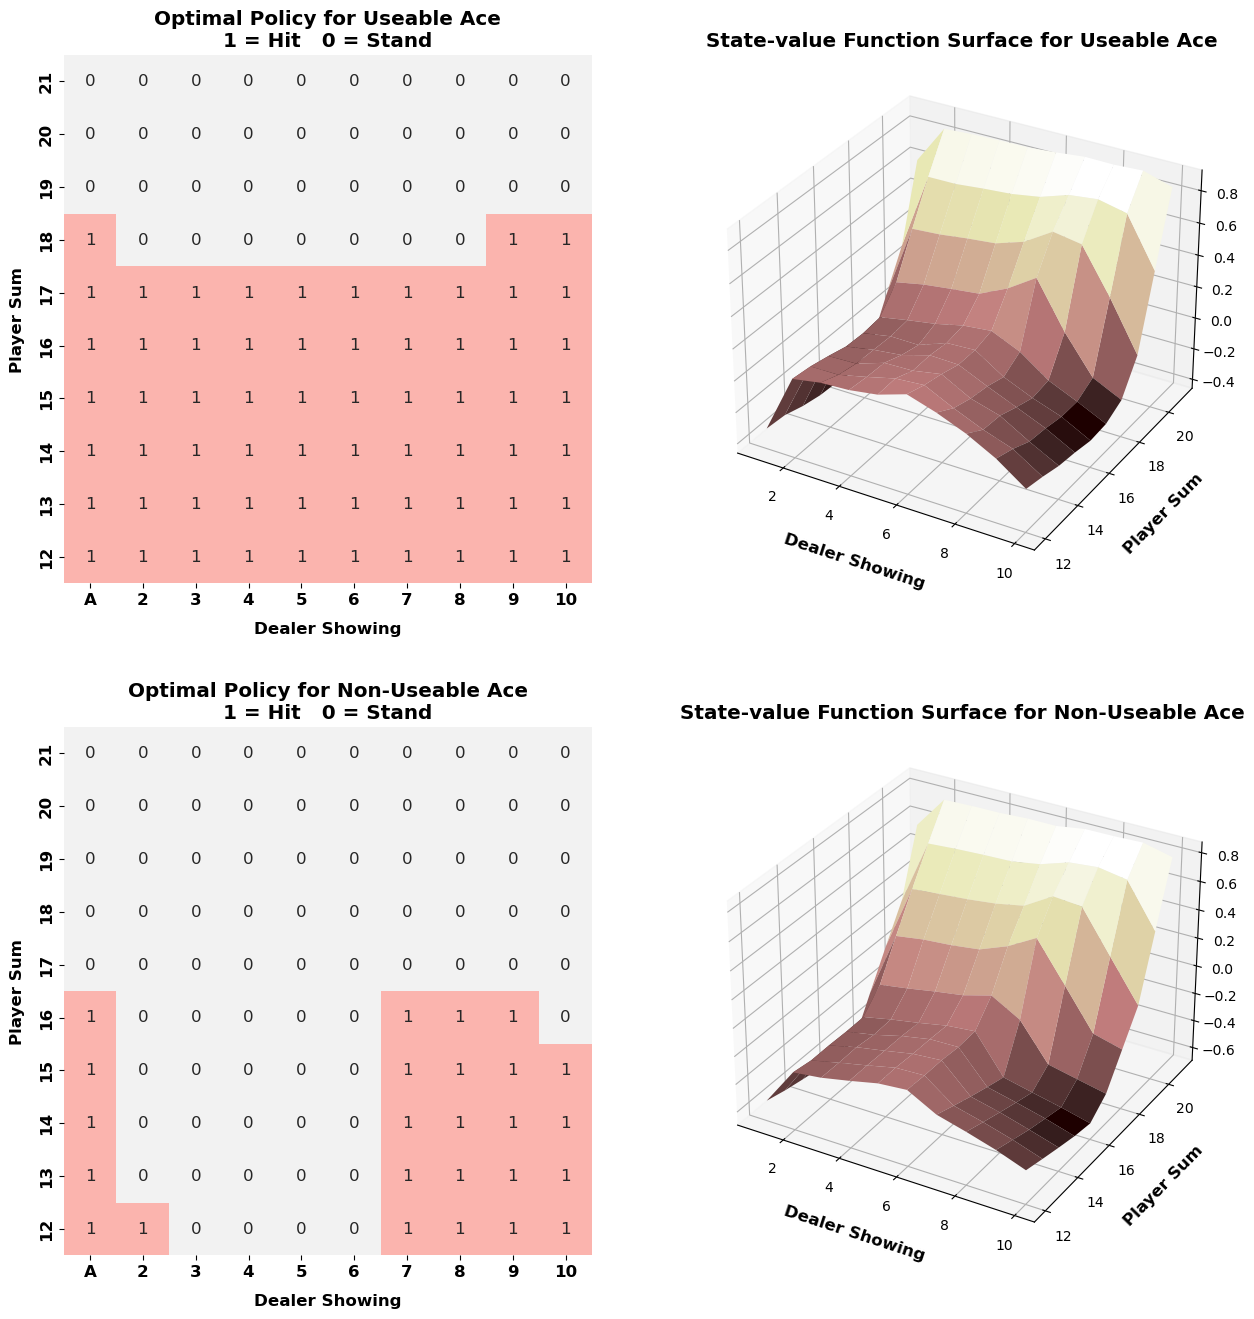

In [10]:
fig = plt.figure(figsize=(15,16))
cmap='Pastel1_r'
cmap2='pink'

# create data for plotting
ua_policy = np.round(π[:,:,1,1])
nua_policy = np.round(π[:,:,0,1])
ua_v = (sa_returns[:,:,1,0] + sa_returns[:,:,1,1])/(sa_counter[:,:,1,0] + sa_counter[:,:,1,1])
nua_v = (sa_returns[:,:,0,0] + sa_returns[:,:,0,1])/(sa_counter[:,:,0,0] + sa_counter[:,:,0,1])

# get column that represents dealer showing ace on left side to match sutton and barto plots
ua_policy = ua_policy[:,[9,0,1,2,3,4,5,6,7,8]]
nua_policy = nua_policy[:,[9,0,1,2,3,4,5,6,7,8]]
ua_v = ua_v[:,[9,0,1,2,3,4,5,6,7,8]]
nua_v = nua_v[:,[9,0,1,2,3,4,5,6,7,8]]

# reverse order of player sum
ua_policy = ua_policy[list(reversed(range(10))),:]
nua_policy = nua_policy[list(reversed(range(10))),:]
ua_v = ua_v[list(reversed(range(10))),:]
nua_v = nua_v[list(reversed(range(10))),:]

# convert numpy arrays to pandas dataframes
ua_policy = pd.DataFrame(ua_policy, index = np.arange(12,22)[::-1], columns = ['A',2,3,4,5,6,7,8,9,10])
nua_policy = pd.DataFrame(nua_policy, index = np.arange(12,22)[::-1], columns = ['A',2,3,4,5,6,7,8,9,10])
ua_v = pd.DataFrame(ua_v, index = np.arange(12,22)[::-1], columns = [1,2,3,4,5,6,7,8,9,10])
nua_v = pd.DataFrame(nua_v, index = np.arange(12,22)[::-1], columns = [1,2,3,4,5,6,7,8,9,10])

# plotting useable ace policy
ax1 = fig.add_subplot(221)
sns.heatmap(ua_policy, ax=ax1, annot=True, annot_kws={'fontsize':'large'}, cmap=cmap, cbar=False, square=True)
ax1.set_title('Optimal Policy for Useable Ace\n1 = Hit   0 = Stand', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)
plt.xticks(fontsize='large', fontweight='bold') 
plt.yticks(fontsize='large', fontweight='bold') 

# plotting non-useable ace policy
ax2 = fig.add_subplot(223)
sns.heatmap(nua_policy, ax=ax2, annot=True, annot_kws={'fontsize':'large'}, cmap=cmap, cbar=False, square=True)
ax2.set_title('Optimal Policy for Non-Useable Ace\n1 = Hit   0 = Stand', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)
plt.xticks(fontsize='large', fontweight='bold')
plt.yticks(fontsize='large', fontweight='bold') 

# plotting useable ace state-value function surface
ax3 = fig.add_subplot(222, projection='3d')
X, Y = np.meshgrid(ua_v.columns.values, ua_v.index.values)
ax3.plot_surface(X,Y, ua_v, cmap=cmap2)
ax3.set_title('State-value Function Surface for Useable Ace', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)

# plotting non-useable ace state-value function surface
ax4 = fig.add_subplot(224, projection='3d')
X, Y = np.meshgrid(nua_v.columns.values, nua_v.index.values)
ax4.plot_surface(X,Y, nua_v, cmap=cmap2)
ax4.set_title('State-value Function Surface for Non-Useable Ace', fontsize='x-large', fontweight='bold')
plt.xlabel('Dealer Showing', fontweight='bold', fontsize='large', labelpad=10)
plt.ylabel('Player Sum', fontweight='bold', fontsize='large', labelpad=10)

plt.show()

Compared to Sutton and Barto's results:

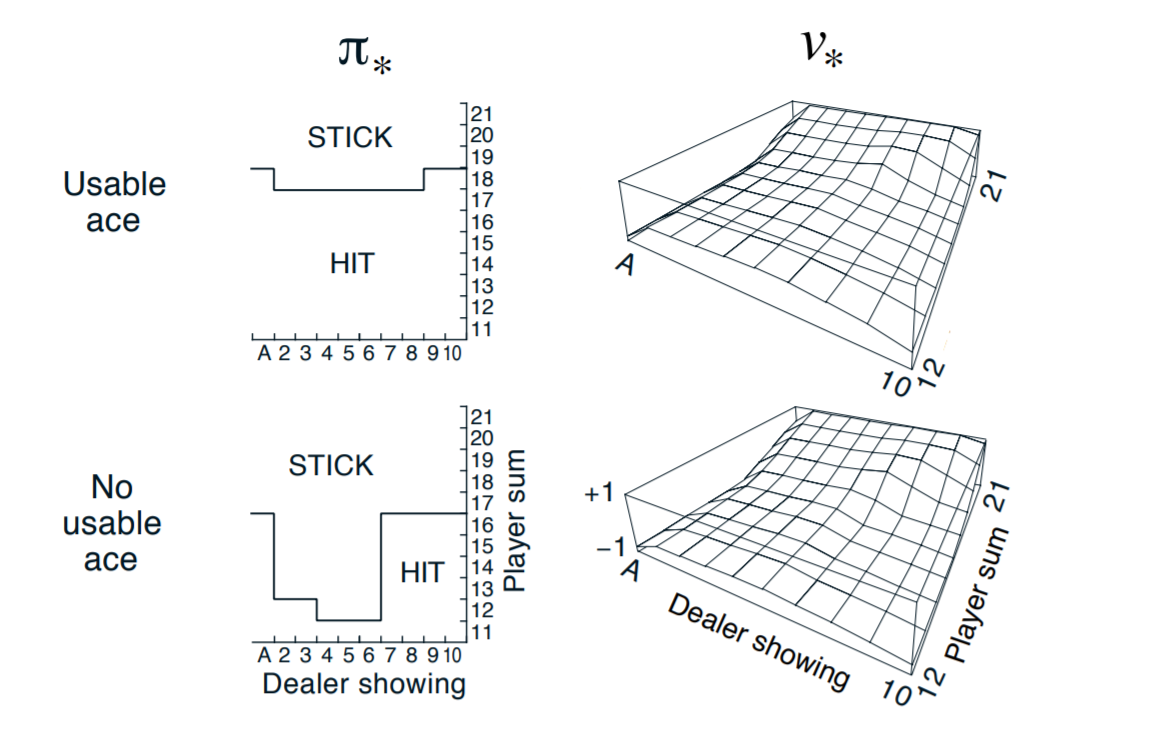